# Biomedical Image Segmentation with U-Net

The Dice coefficient (the standard metric for the BraTS dataset used in the study) for this model is about 0.82-0.88.  Menze et al. [reported](http://ieeexplore.ieee.org/document/6975210/) that expert neurophysiologists manually segmented these tumors with a cross-rater Dice score of 0.75–0.85, meaning that the model’s predictions are on par with what expert physicians have made.

In [1]:
import sys
import platform
import time

import settings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

plt.rcParams['font.family'] = settings.FONT_FAMILY
plt.rcParams['figure.dpi'] = 300
%matplotlib inline

print("Platform:              {}".format(platform.platform()))
print("Python version:        {}".format(sys.version))
print("TensorFlow version:    {}".format(tf.__version__))
gpu_status = "Available" if tf.config.list_physical_devices("GPU") else "Not Available"
color = "\033[92m" if gpu_status == "Available" else "\033[91m"
reset = "\033[0m"
print(f"GPU Status:            {color}{gpu_status}{reset}")

Platform:              macOS-15.4.1-arm64-arm-64bit
Python version:        3.10.11 (v3.10.11:7d4cc5aa85, Apr  4 2023, 19:05:19) [Clang 13.0.0 (clang-1300.0.29.30)]
TensorFlow version:    2.15.0
GPU Status:            Available


In [2]:
data_path = settings.TRAIN_DATA_PATH

seed = settings.SEED
crop_dim = settings.CROP_DIM
batch_size = settings.BATCH_SIZE
train_test_split = settings.TRAIN_TEST_SPLIT

## What is U-Net?
U-Net is designed like an [auto-encoder](https://en.wikipedia.org/wiki/Autoencoder). It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape.  However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole. For each pixel in the original image, it asks: “To which class does this pixel belong?” This flexibility allows U-Net to predict different parts of the tumor simultaneously.

<img src="images/unet.png">

## Training Phase

### Step 1: Loading the BraTS dataset from the `tf.data` loader

In [3]:
from dataloader import DatasetGenerator, get_decathlon_filelist

trainFiles, validateFiles, testFiles = get_decathlon_filelist(data_path=data_path, seed=seed, split=train_test_split)

ds_train = DatasetGenerator(trainFiles + testFiles,
                            batch_size=batch_size,
                            crop_dim=(crop_dim, crop_dim),
                            augment=True,
                            seed=seed,
                            dim=3
                            )

ds_validation = DatasetGenerator(validateFiles,
                                 batch_size=batch_size,
                                 crop_dim=(crop_dim, crop_dim),
                                 augment=False,
                                 seed=seed,
                                 dim=3
                                 )

# ds_test = DatasetGenerator(testFiles,
#                            batch_size=batch_size,
#                            crop_dim=(crop_dim, crop_dim),
#                            augment=False,
#                            seed=seed,
#                            dim=3
#                            )


******************************
Dataset name:         BRATS2021
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    3D
Dataset release:      Not provided
Dataset reference:    http://braintumorsegmentation.org/
Dataset license:      CC-BY-SA 4.0
******************************
Number of training files   = 1000
Number of validation files = 125
Number of testing files    = 126


### Step 2: Define the model

In [4]:
from model import UNet2D

print("-" * 28)
print("Creating and compiling model")
print("-" * 28)

unet_model = UNet2D(fms=8, learning_rate=1e-4, use_dropout=False, use_up_sampling=False)

model = unet_model.create_model(
    ds_train.get_input_shape(),
    ds_train.get_output_shape()
)

model_filename, model_callbacks = unet_model.get_callbacks()

# # If there is a current saved file, then load weights and start from there.
# saved_model = os.path.join(settings.OUTPUT_PATH, settings.INFERENCE_FILENAME)
# if os.path.isfile(saved_model):
#     model.load_weights(saved_model)

----------------------------
Creating and compiling model
----------------------------
Data format = channels_last
Using Transposed Convolution


2025-05-07 20:49:43.368682: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-07 20:49:43.368882: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-07 20:49:43.368894: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-07 20:49:43.369136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-07 20:49:43.369411: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "UNet2D"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 MRImages (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 encodeAa (Conv2D)           (None, 128, 128, 8)          80        ['MRImages[0][0]']            
                                                                                                  
 encodeAb (Conv2D)           (None, 128, 128, 8)          584       ['encodeAa[0][0]']            
                                                                                                  
 poolA (MaxPooling2D)        (None, 64, 64, 8)            0         ['encodeAb[0][0]']            
                                                                                             

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


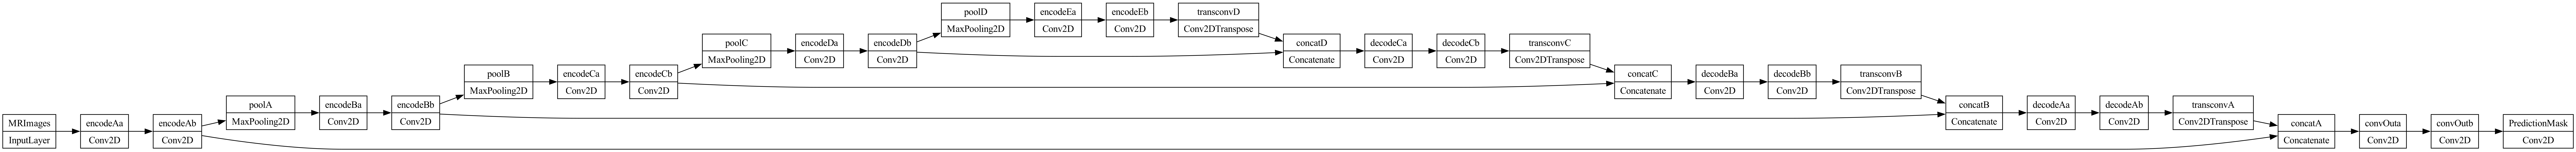

In [5]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model,
           to_file='images/model.png',
           # show_shapes=True,
           # show_layer_names=True,
           rankdir='LR',
           dpi=300
           )
Image('images/model.png')

### Step 3: Train the model on the data

In [6]:
import datetime

start_time = datetime.datetime.now()
print("Training started at {}".format(start_time))

n_epoch = settings.EPOCHS  # Train for this many epochs

device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
with tf.device(device):
    history = model.fit(ds_train,
                        epochs=n_epoch,
                        validation_data=ds_validation,
                        verbose=1,
                        callbacks=model_callbacks
                        )

end_time = datetime.datetime.now()
print("Total time elapsed for training = {} seconds".format(end_time - start_time))
print("Training finished at {}".format(datetime.datetime.now()))

# Append training log
# with open("training.log","a+") as fp:
#     fp.write("{}: {}\n".format(datetime.datetime.now(),
#                              history.history["val_dice_coef"]))

Training started at 2025-05-07 20:49:44.854439
Epoch 1/3


2025-05-07 20:49:47.085597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1363/1363 [==============================] - ETA: 0s - loss: 0.9824 - dice_coefficient: 0.5637 - soft_dice_coefficient: 0.1929 - sensitivity: 0.8380 - specificity: 0.9146INFO:tensorflow:Assets written to: ./output/2d_unet_decathlon/assets


INFO:tensorflow:Assets written to: ./output/2d_unet_decathlon/assets


1363/1363 [==============================] - 218s 153ms/step - loss: 0.9824 - dice_coefficient: 0.5637 - soft_dice_coefficient: 0.1929 - sensitivity: 0.8380 - specificity: 0.9146 - val_loss: 0.3783 - val_dice_coefficient: 0.5638 - val_soft_dice_coefficient: 0.3094 - val_sensitivity: 0.8352 - val_specificity: 0.9869 - lr: 1.0000e-04
Epoch 2/3
1363/1363 [==============================] - ETA: 0s - loss: 0.5335 - dice_coefficient: 0.6972 - soft_dice_coefficient: 0.2444 - sensitivity: 0.8512 - specificity: 0.9800INFO:tensorflow:Assets written to: ./output/2d_unet_decathlon/assets


INFO:tensorflow:Assets written to: ./output/2d_unet_decathlon/assets


1363/1363 [==============================] - 194s 142ms/step - loss: 0.5335 - dice_coefficient: 0.6972 - soft_dice_coefficient: 0.2444 - sensitivity: 0.8512 - specificity: 0.9800 - val_loss: 0.2918 - val_dice_coefficient: 0.7788 - val_soft_dice_coefficient: 0.3417 - val_sensitivity: 0.8283 - val_specificity: 0.9938 - lr: 1.0000e-04
Epoch 3/3
1363/1363 [==============================] - ETA: 0s - loss: 0.4779 - dice_coefficient: 0.7006 - soft_dice_coefficient: 0.2614 - sensitivity: 0.8651 - specificity: 0.9805INFO:tensorflow:Assets written to: ./output/2d_unet_decathlon/assets


INFO:tensorflow:Assets written to: ./output/2d_unet_decathlon/assets


1363/1363 [==============================] - 190s 139ms/step - loss: 0.4779 - dice_coefficient: 0.7006 - soft_dice_coefficient: 0.2614 - sensitivity: 0.8651 - specificity: 0.9805 - val_loss: 0.2759 - val_dice_coefficient: 0.7374 - val_soft_dice_coefficient: 0.3563 - val_sensitivity: 0.9054 - val_specificity: 0.9857 - lr: 1.0000e-04
Total time elapsed for training = 0:10:02.318397 seconds
Training finished at 2025-05-07 20:59:47.173083


### Step 4: Evaluate the best model

In [7]:
font = {'fontname': settings.FONT_FAMILY}
prop = font_manager.FontProperties(family=settings.FONT_FAMILY, size=settings.FONT_SIZE)

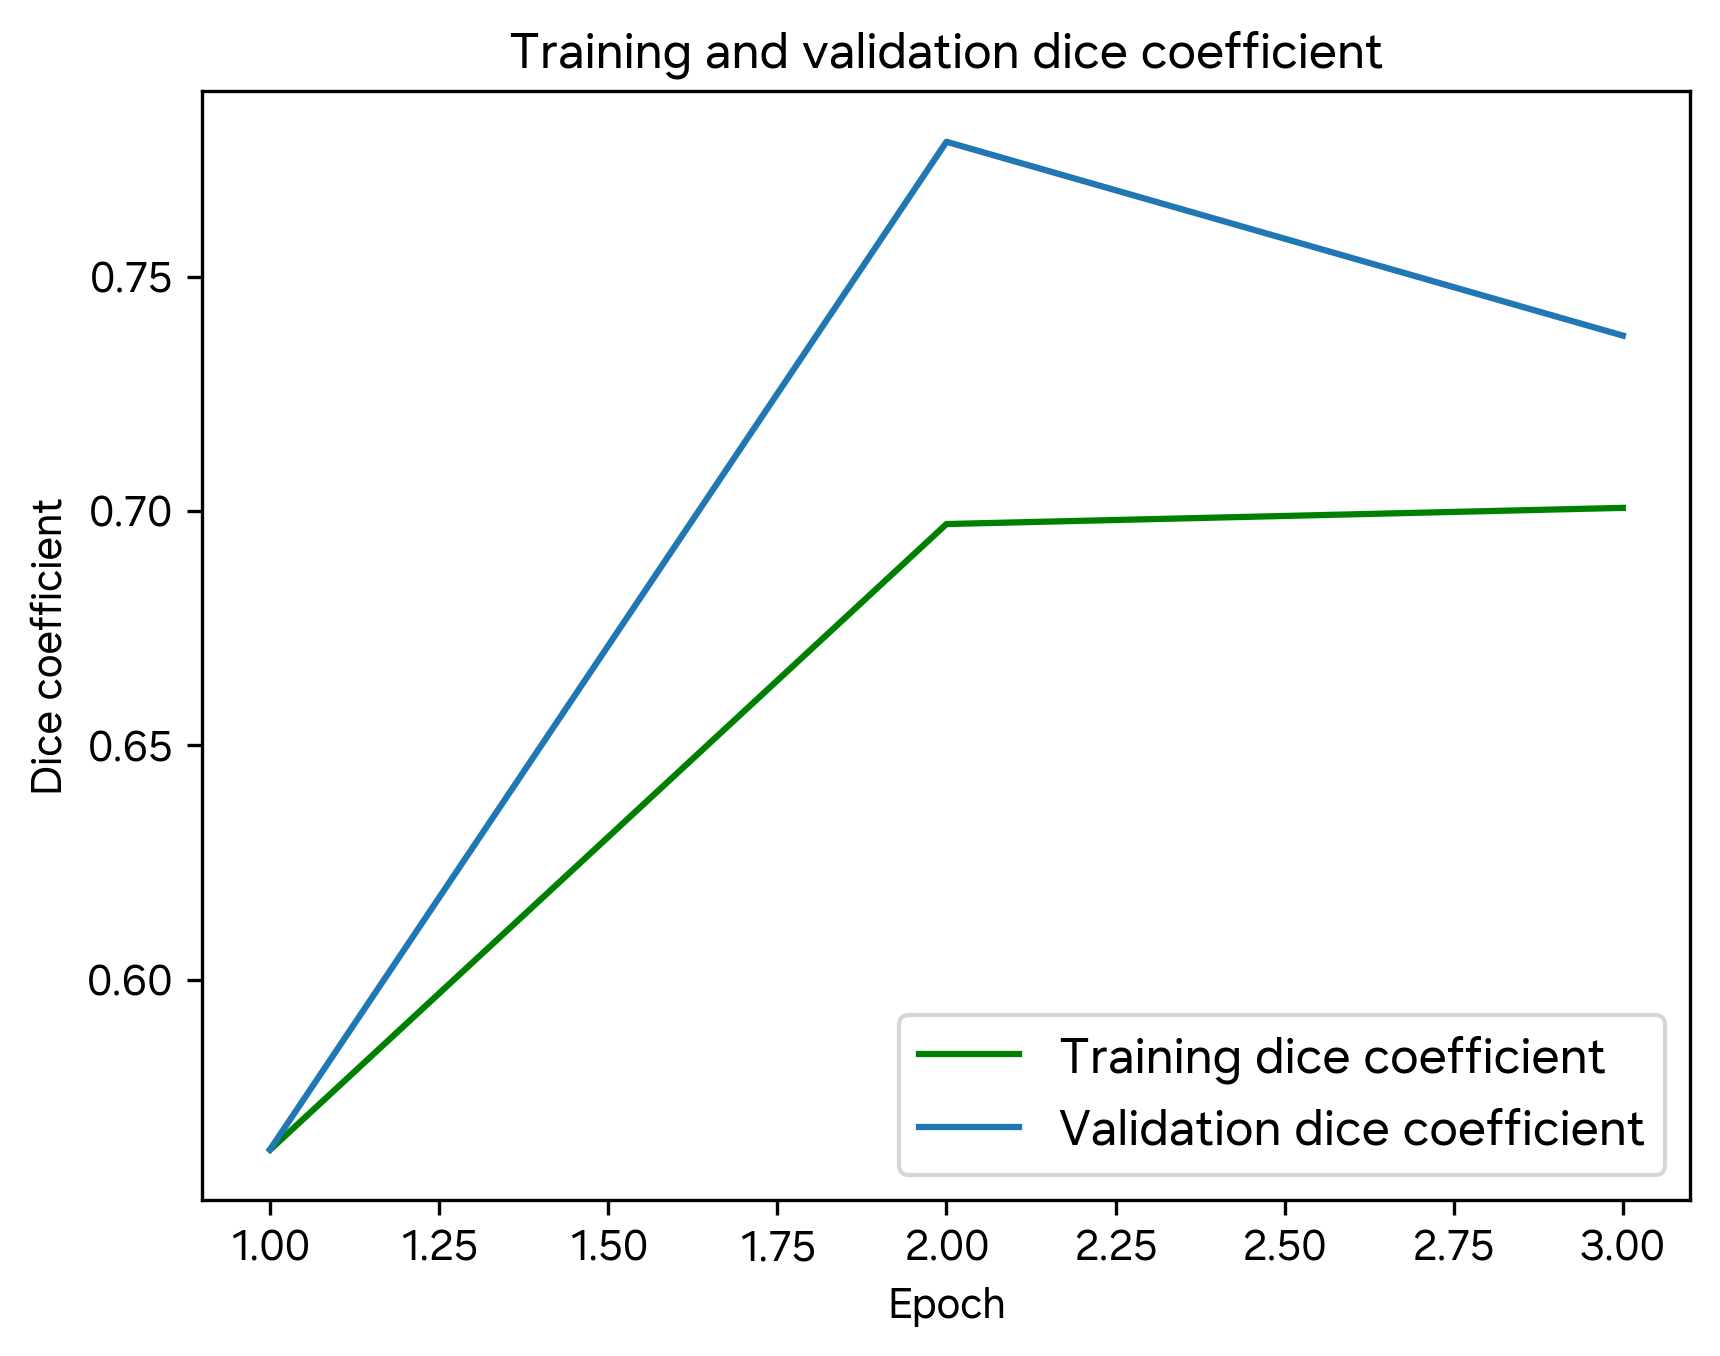

In [8]:
epochs = range(1, len(history.history['loss']) + 1)
dice_coefficient = history.history['dice_coefficient']
val_dice_coefficient = history.history['val_dice_coefficient']

plt.figure(dpi=300)
plt.plot(epochs, dice_coefficient, '-', label="Training dice coefficient", color="green", markevery=1)
plt.plot(epochs, val_dice_coefficient, '-', label="Validation dice coefficient")
plt.xlabel('Epoch', **font)
plt.ylabel('Dice coefficient', **font)
plt.legend(prop=prop)
plt.title('Training and validation dice coefficient', **font)
plt.savefig(f'images/dice_coefficient_{datetime.datetime.now()}.png')
plt.show()

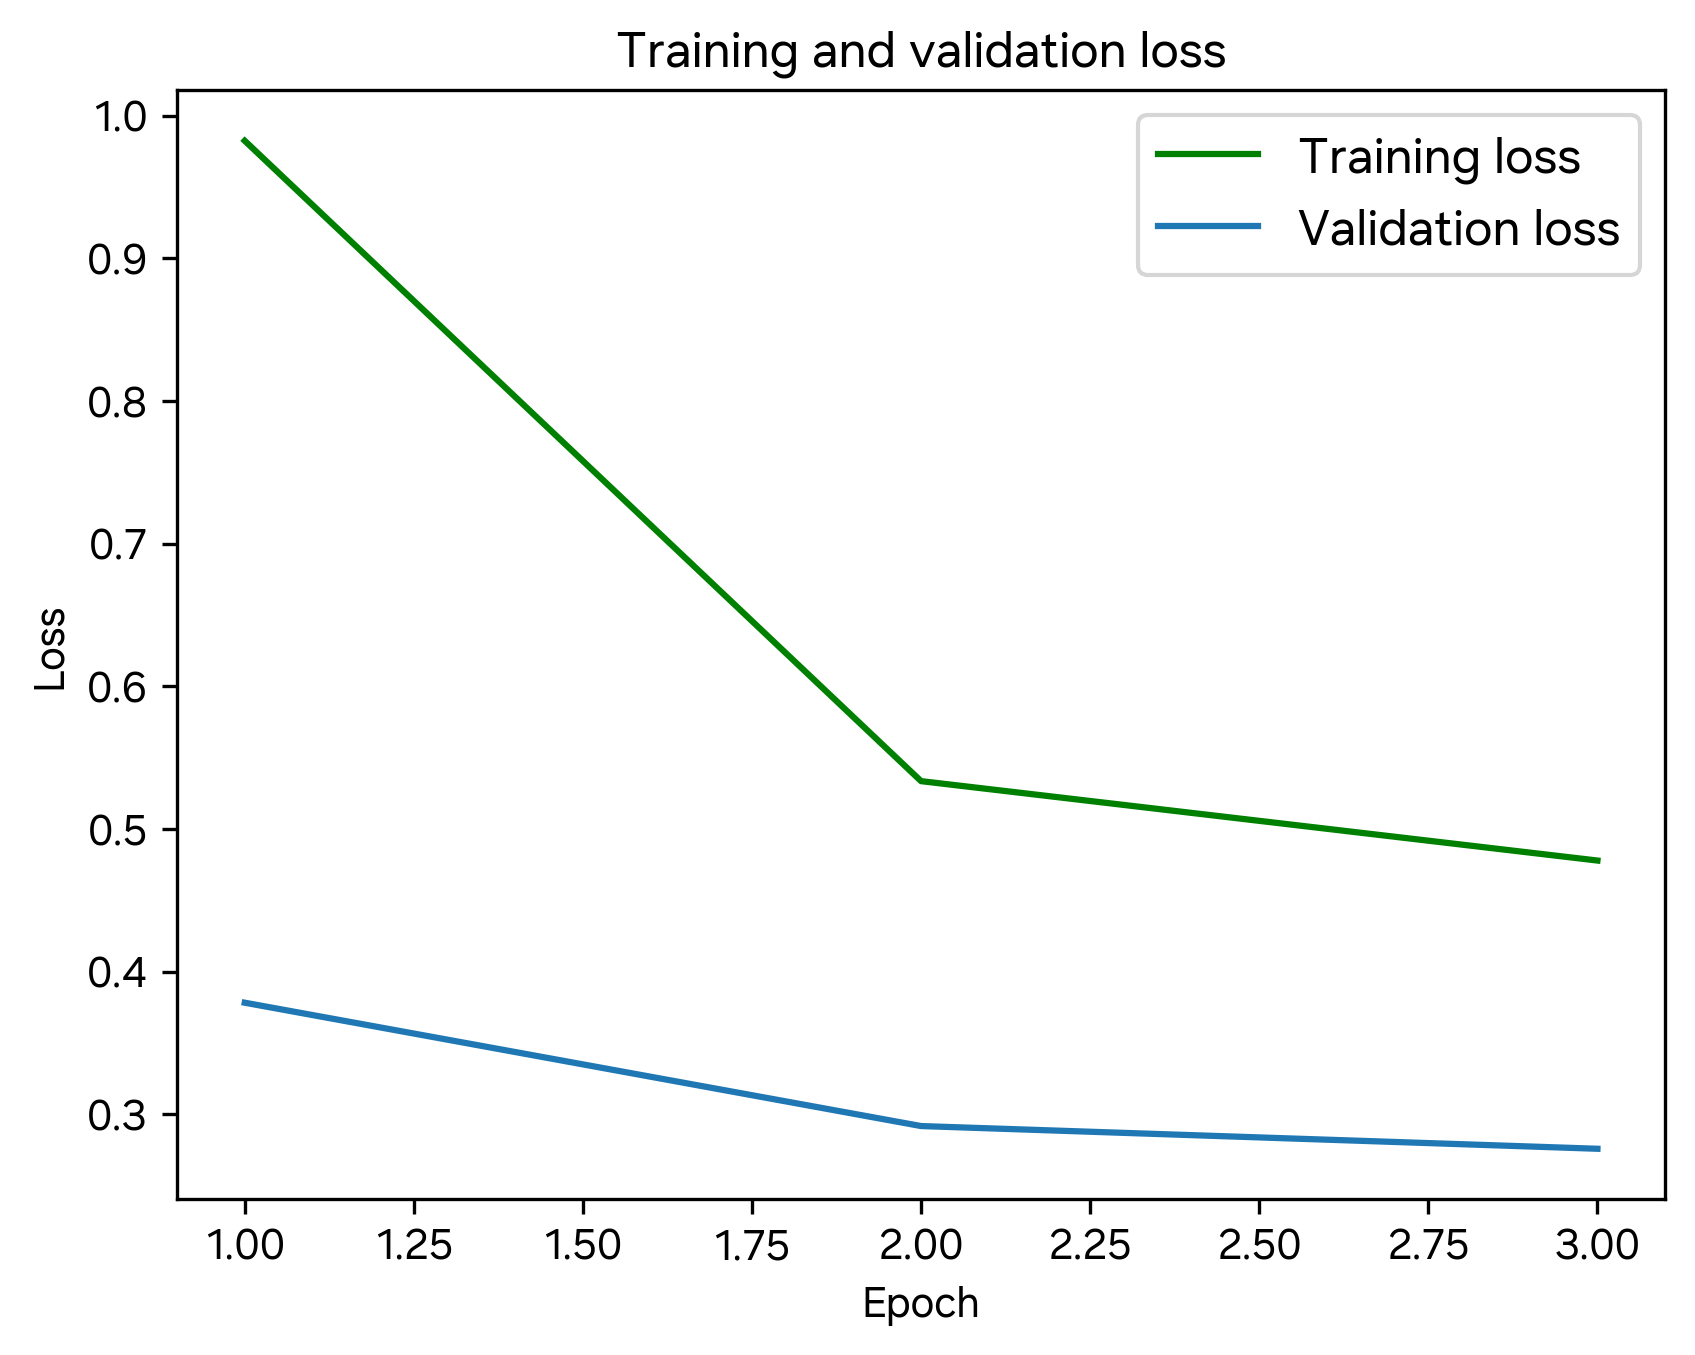

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(dpi=300)
plt.plot(epochs, history.history['loss'], '-', label="Training loss", color="green", markevery=1)
plt.plot(epochs, val_loss, '-', label="Validation loss")
plt.xlabel('Epoch', **font)
plt.ylabel('Loss', **font)
plt.legend(prop=prop)
plt.title('Training and validation loss', **font)
plt.savefig(f'images/loss_{datetime.datetime.now()}.png')
plt.show()